# Problem Set 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad_vec

The integrated flux density is given by

$$
F_{\nu,disk} = \int_{R_{min}}^{R_{max}} \underbrace{B_{\nu}(T)}_{\text{(a)}} \underbrace{\big[ 1-e^{-\kappa_{\nu}\Sigma/\cos i} \big]}_{\text{(b)}} \underbrace{\frac{2\pi r dr \cos i}{d^2}}_{\text{(c)}}
$$

where:

(a) Blackbody emission from the dust at some temperature $T$, which will be dependent on the radius in the disk

(b) Frequency dependence from the optical depth, i.e., $1 - e^{-\tau_\nu}$, since it will emit more when $\tau_\nu$ is larger

(c) Integrating rings out from the center to cover the area of the disk, then scale down for the distance to the object $d$ (and viewing angle)

In [2]:
aa_tau = np.loadtxt('aa_tau.txt', skiprows=11, usecols=(0,1))
aa_tau = aa_tau.T

T_EFF = 4060 # effective temperature in K
L = 0.87 # luminosity in L_sun
A_V = 1.3 # visual extinction
I = 59*np.pi/180 # inclination in radians
PARALLAX = 7.43e-3 # in arcseconds
D = 3.086e16/PARALLAX # distance to AA Tau in m

H = 6.626e-34 # Planck's constant in m^2 kg/s
C = 3e8 # speed of light in m/s
K_B = 1.38e-23 # Boltzmann's constant in m^2 kg/s^2/K

## Part 1

The contribution from the star is predictable. For the disk, we obtain $T_1=100 \text{ K}$ and $\Sigma_1 = 20 \text{ g/cm}^2$.

In [3]:
def planck(nu, Teff):
    """
    Returns the value of Planck's function.
    
    PARAMETERS
    nu: (float) the frequency in Hz
    Teff: (float) the temperature in K
    """
    return 2*H*nu**3/C**2/(np.exp(H*nu/(K_B*Teff))-1)

def extinction(l):
    """
    Returns A_lambda/A_V for the given wavelength, according to eqs. (9) and (10) of
    Wang & Chen 2019.
    
    PARAMETERS
    l: (float) the wavelength in microns
    """
    y = 1/l - 1.82
    # optical 0.3 < l < 1
    f1 = lambda x: 1 + 0.7499*x - 0.1086*x**2 - 0.08909*x**3 + 0.02905*x**4 \
                    + 0.01069*x**5 + 0.001707*x**6 - 0.001002*x**7
    # NIR 1 <= l < 3.33
    f2 = lambda x: 0.3722*x**(-2.070)
    return np.where(l<1, f1(y), f2(l))

def sed_star(nu):
    """
    Returns the SED of the star with extinction.
    
    PARAMETERS:
    nu: (float) the frequency in Hz
    """
    A_star = (4*np.pi*7e8**2) * (5778/T_EFF)**4 * L # surface area in m^2
    F_nu_emit_star = planck(nu, T_EFF) * 2*np.pi * A_star/2 # emitted flux density W/Hz
    F_nu_obs_star = F_nu_emit_star / (4*np.pi*D**2) # recieved flux density W/m^2/Hz
    ext_corr = 10**(-0.4*extinction(1e6*C/nu)*A_V) # obtain scale factor for reddening
    return nu*F_nu_obs_star*ext_corr

def sed_disk(nu, rmin, rmax, s1, t1, q, beta):
    """
    Returns the SED of the disk with extinction.
    
    PARAMETERS
    nu: (float) the frequency in Hz
    rmin: (float) the minimum radius in the disk in AU
    rmax: (float) the maximum radius in the disk in AU
    s1: (float) the surface density of the disk at 1 AU in g/cm^2
    t1: (float) the temperature of the disk at 1 AU in K
    q: (float) the temperature scaling index
    beta: (float) the dust opacity index
    """
    kappa0 = 1 # in m^2/kg
    nu0 = 1e12 # in Hz
    
    kappa = kappa0*(nu/nu0)**beta
    Sigma_r = lambda r: 10*s1*r**-1 # convert to kg/m^2
    T_r = lambda r: t1*r**(-q)
    integrand = lambda r: planck(nu, T_r(r))*(1-np.exp(-kappa*Sigma_r(r)/np.cos(I))) \
                            * 2*np.pi*r*np.cos(I)/D**2 * 1.5e11**2 # convert AU to m
    
    F_nu_obs_disk = quad_vec(integrand, rmin, rmax)[0]
    ext_corr = 10**(-0.4*extinction(1e6*C/nu)*A_V) # obtain scale factor for reddening
    return nu*F_nu_obs_disk*ext_corr

A_l = A_V*extinction(aa_tau[0])
F_nu_obs_data = aa_tau[1]*1e-26*C/(aa_tau[0]*1e-6)
waves = np.logspace(np.log10(0.3), np.log10(3e3), 100) # in microns
nus = C/(waves*1e-6) # in Hz

T0 = 100
S0 = 20
star_model = sed_star(nus)
disk_model = sed_disk(nus, 0.03, 100, S0, T0, 0.75, 1)

plt.figure(figsize=(12,8))
plt.scatter(aa_tau[0], F_nu_obs_data, label='Observations', c='coral')
plt.plot(waves, star_model, '--', label='Star', c='grey')
plt.plot(waves, disk_model, ':', label='Flat disk', c='grey')
plt.plot(waves, star_model+disk_model, label='Star+disk', c='lightseagreen')
plt.xlabel(r'$\lambda (\mu m)$', fontsize=14)
plt.ylabel(r'$\nu F_{\nu} (W/m^2)$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3, 4000)
plt.ylim(5e-18, 2e-12)
plt.legend(fontsize=12)
plt.show()

<ipython-input-3-e396e2a99eb3>:9: RuntimeWarning: overflow encountered in exp
  return 2*H*nu**3/C**2/(np.exp(H*nu/(K_B*Teff))-1)


# Part 2

The ratios are:

$$
\begin{align}
\frac{T_{interior}}{T_{surface}} & = 0.24 \\
\frac{\Sigma_{interior}}{\Sigma_{surface}} & = 16 .
\end{align}
$$

As expected, the interior of the disk is significantly cooler than the surface because it's shielded from the star's radiation. There is also a higher mass density because the heavier particles settle.

In [4]:
T1 = 35 # disk interior temperature in K
S1 = 8
T2 = 145 # disk surface temperature in K
S2 = 0.5
disk_int_model = sed_disk(nus, 0.03, 100, S1, T1, 3/7, 1)
disk_surf_model = sed_disk(nus, 0.03, 100, S2, T2, 0.55, 1)

print('Tint/Text = ' + '{:.2f}'.format(T1/T2))
print('Sint/Sext = ' + '{:.2f}'.format(S1/S2))

plt.figure(figsize=(12,8))
plt.scatter(aa_tau[0], F_nu_obs_data, label='Observations', c='coral')
plt.plot(waves, star_model, '--', label='Star', c='grey')
plt.plot(waves, disk_surf_model, ':', label='Surface', c='grey')
plt.plot(waves, disk_int_model, '-.', label='Interior', c='grey')
plt.plot(waves, star_model+disk_surf_model+disk_int_model, label='Star+disk', c='lightseagreen')
plt.xlabel(r'$\lambda (\mu m)$', fontsize=14)
plt.ylabel(r'$\nu F_{\nu} (W/m^2)$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3, 4000)
plt.ylim(5e-18, 2e-12)
plt.legend(fontsize=12)
plt.show()

Tint/Text = 0.24
Sint/Sext = 16.00


<ipython-input-3-e396e2a99eb3>:9: RuntimeWarning: overflow encountered in exp
  return 2*H*nu**3/C**2/(np.exp(H*nu/(K_B*Teff))-1)


## Part 3

Playing with the parameters of $F_{\nu, disk}$, we find that:
- $\beta$ changes the slope of the right edge
- $R_{min}$ changes the size of the middle left dip
- $R_{max}$ changes the location of the right edge.

<ipython-input-3-e396e2a99eb3>:9: RuntimeWarning: overflow encountered in exp
  return 2*H*nu**3/C**2/(np.exp(H*nu/(K_B*Teff))-1)


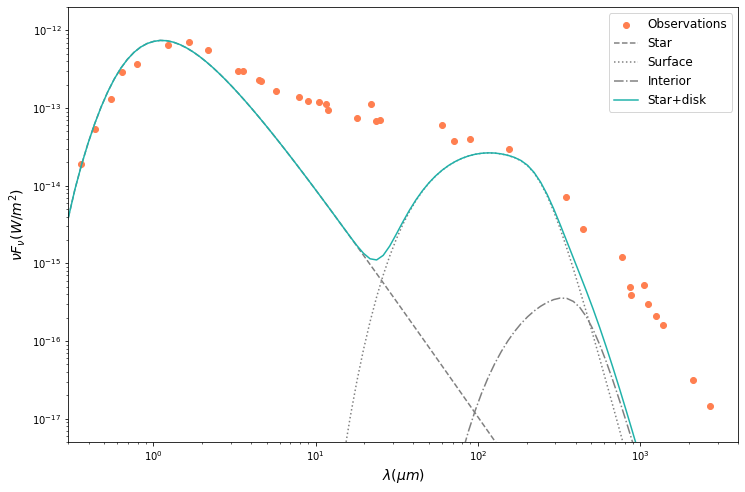

In [5]:
beta = 5 # playing with these parameters for this part of the question...
Rmin = 5
Rmax = 50
disk_int_model = sed_disk(nus, Rmin, Rmax, S1, T1, 3/7, beta)
disk_surf_model = sed_disk(nus, Rmin, Rmax, S2, T2, 0.55, beta)

plt.figure(figsize=(12,8))
plt.scatter(aa_tau[0], F_nu_obs_data, label='Observations', c='coral')
plt.plot(waves, star_model, '--', label='Star', c='grey')
plt.plot(waves, disk_surf_model, ':', label='Surface', c='grey')
plt.plot(waves, disk_int_model, '-.', label='Interior', c='grey')
plt.plot(waves, star_model+disk_surf_model+disk_int_model, label='Star+disk', c='lightseagreen')
plt.xlabel(r'$\lambda (\mu m)$', fontsize=14)
plt.ylabel(r'$\nu F_{\nu} (W/m^2)$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3, 4000)
plt.ylim(5e-18, 2e-12)
plt.legend(fontsize=12)
plt.show()

## Part 4

We can split the integral for $F_{\nu, disk}$ so that we don't integrate over the radii where the gap is located.

$$
F_{\nu,disk} = \int_{R_{disk,min}}^{R_{gap,min}} B_{\nu}(T) \big[ 1-e^{-\kappa_{\nu}\Sigma/\cos i} \big] \frac{2\pi r dr \cos i}{d^2} + \int_{R_{gap,max}}^{R_{disk,max}} B_{\nu}(T) \big[ 1-e^{-\kappa_{\nu}\Sigma/\cos i} \big] \frac{2\pi r dr \cos i}{d^2}
$$

For illustrative purposes, I've chosen $R_{gap,min}=5 \text{ AU}$ and $R_{gap,max}=15 \text{ AU}$. There's now a decreasing bump in the part of the SED that comes from the disk. Roughly speaking, each radius in the disk contributes flux at a certain temperature, which then corresponds to a specific wavelength from Wien's law. By removing some radii from the disk, we're losing flux from their corresponding wavelengths.


<ipython-input-3-e396e2a99eb3>:9: RuntimeWarning: overflow encountered in exp
  return 2*H*nu**3/C**2/(np.exp(H*nu/(K_B*Teff))-1)


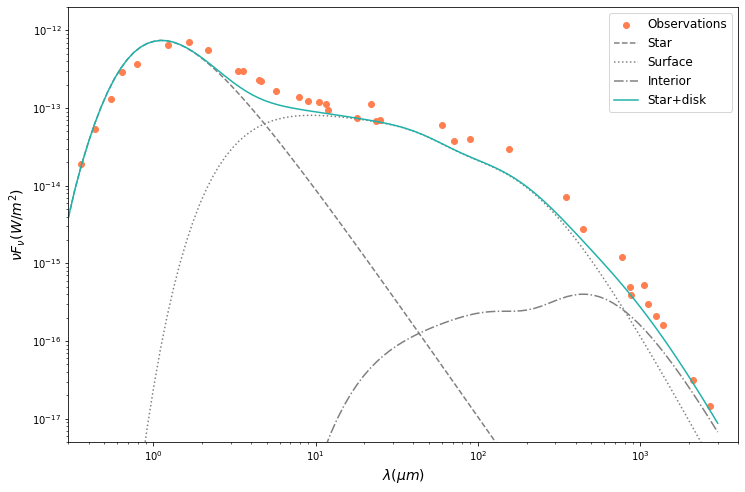

In [6]:
def sed_disk_gap(nu, rmin, rmax, gapmin, gapmax, S1, T1, q, beta):
    """
    Returns the SED using the flat disk model with extinction.
    
    PARAMETERS
    nu: (float) the frequency in Hz
    rmin: (float) the minimum radius in the disk in AU
    rmin: (float) the maximum radius in the disk in AU
    gapmin: (float) the minimum radius of the gap in AU
    gapmax: (float) the maximum radius of the gap in AU
    S1: (float) the surface density of the disk at 1 AU in g/cm^2
    T1: (float) the temperature of the disk at 1 AU in K
    q: (float) the temperature scaling index
    beta: (float) the dust opacity index
    """
    kappa0 = 1 # in m^2/kg
    nu0 = 1e12 # in Hz
    
    kappa = kappa0*(nu/nu0)**beta
    Sigma_r = lambda r: 10*S1*r**-1 # convert to kg/m^2
    T_r = lambda r: T1*r**(-q)
    integrand = lambda r: planck(nu, T_r(r))*(1-np.exp(-kappa*Sigma_r(r)/np.cos(I))) \
                            * 2*np.pi*r*np.cos(I)/D**2 * 1.5e11**2 # convert AU to m
    
    F_nu_obs_disk = quad_vec(integrand, rmin, gapmin)[0] + quad_vec(integrand, gapmax, rmax)[0]
    ext_corr = 10**(-0.4*extinction(1e6*C/nu)*A_V) # obtain scale factor for reddening
    return nu*F_nu_obs_disk*ext_corr

beta = 1
Rmin = 0.03
Rmax = 100
gapmin = 5
gapmax = 15
disk_int_model = sed_disk_gap(nus, Rmin, Rmax, gapmin, gapmax, S1, T1, 3/7, beta)
disk_surf_model = sed_disk_gap(nus, Rmin, Rmax, gapmin, gapmax, S2, T2, 0.55, beta)

plt.figure(figsize=(12,8))
plt.scatter(aa_tau[0], F_nu_obs_data, label='Observations', c='coral')
plt.plot(waves, star_model, '--', label='Star', c='grey')
plt.plot(waves, disk_surf_model, ':', label='Surface', c='grey')
plt.plot(waves, disk_int_model, '-.', label='Interior', c='grey')
plt.plot(waves, star_model+disk_surf_model+disk_int_model, label='Star+disk', c='lightseagreen')
plt.xlabel(r'$\lambda (\mu m)$', fontsize=14)
plt.ylabel(r'$\nu F_{\nu} (W/m^2)$', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.3, 4000)
plt.ylim(5e-18, 2e-12)
plt.legend(fontsize=12)
plt.show()